# Credit Risk Default Prediction (Home Credit)

This project builds a machine learning model to estimate the probability that a customer will default on a loan.

**What this notebook shows:**
- End-to-end ML pipeline on a real credit dataset
- Handling messy data (nulls, mixed types, leaks)
- Addressing severe class imbalance with SMOTE
- Training and comparing XGBoost, LightGBM, and CatBoost
- Evaluating models using ROC-AUC, confusion matrix, and classification metrics
- Exporting the trained model for later deployment

**Goal:** simulate how a bank scores loan applicants for risk, while keeping the pipeline clean and auditable.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import joblib


## 2. Load Data & Initial Exploration

We load the Home Credit training dataset and take an initial look at:
- shape and column types
- class balance in the target (`TARGET`)
- missing values

`TARGET = 1` means the client had payment difficulties (risky borrower).  
`TARGET = 0` means the client repaid the loan.

In [ ]:
df = pd.read_csv("DATA/Credit Risk.csv")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [5]:
df.shape

(307511, 122)

In [6]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [7]:
df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [8]:
missing_df = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
(missing_df / len(df) * 100).head(30)

COMMONAREA_MEDI             69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MEDI              67.848630
FLOORSMIN_MODE              67.848630
FLOORSMIN_AVG               67.848630
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_AVG             66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_AVG                59.376738
LANDAREA_MEDI               59.376738
LANDAREA_MODE               59.376738
BASEMENTAREA_MODE           58.515956
BASEMENTAREA_MEDI           58.515956
BASEMENTAREA_AVG            58.515956
EXT_SOURCE_1                56.381073
NONLIVINGAREA_MEDI          55.179164
NONLIVINGAREA_AVG           55.179164
NONLIVINGARE

## 3. Data Cleaning & Missing Values

The raw dataset has many engineered features (behavioral, bureau info, demographics) and a lot of sparsity.

**Steps:**
1. Drop any column with more than 40% missing values.
2. For the remaining columns:
   - Numeric features → imputed with median
   - Categorical features → imputed with mode (most frequent value)

This keeps signal while avoiding leakage from high-NA artifacts.

Dropping columns with over 40% > missing values + don't sense to be strong features

In [9]:
threshold = 0.4 
df = df[df.columns[df.isnull().mean() < threshold]]
df.shape

(307511, 73)

In [10]:
missing_df = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
(missing_df / len(df) * 100).head(30)

OCCUPATION_TYPE               31.345545
EXT_SOURCE_3                  19.825307
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
NAME_TYPE_SUITE                0.420148
OBS_30_CNT_SOCIAL_CIRCLE       0.332021
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
DEF_30_CNT_SOCIAL_CIRCLE       0.332021
OBS_60_CNT_SOCIAL_CIRCLE       0.332021
EXT_SOURCE_2                   0.214626
AMT_GOODS_PRICE                0.090403
AMT_ANNUITY                    0.003902
CNT_FAM_MEMBERS                0.000650
DAYS_LAST_PHONE_CHANGE         0.000325
dtype: float64

In [11]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [12]:
df.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 73, dtype: int64

## 4. Exploratory Data Analysis (EDA) Snapshot

Quick sanity checks:
- Are there duplicate rows?
- How many unique values per feature?
- What do numeric distributions look like?

This is mainly to confirm there’s no obvious data corruption before modeling.


In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df.nunique()

SK_ID_CURR                    307511
TARGET                             2
NAME_CONTRACT_TYPE                 2
CODE_GENDER                        3
FLAG_OWN_CAR                       2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY          9
AMT_REQ_CREDIT_BUREAU_WEEK         9
AMT_REQ_CREDIT_BUREAU_MON         24
AMT_REQ_CREDIT_BUREAU_QRT         11
AMT_REQ_CREDIT_BUREAU_YEAR        25
Length: 73, dtype: int64

array([[<Axes: title={'center': 'SK_ID_CURR'}>,
        <Axes: title={'center': 'TARGET'}>,
        <Axes: title={'center': 'CNT_CHILDREN'}>,
        <Axes: title={'center': 'AMT_INCOME_TOTAL'}>,
        <Axes: title={'center': 'AMT_CREDIT'}>,
        <Axes: title={'center': 'AMT_ANNUITY'}>,
        <Axes: title={'center': 'AMT_GOODS_PRICE'}>,
        <Axes: title={'center': 'REGION_POPULATION_RELATIVE'}>],
       [<Axes: title={'center': 'DAYS_BIRTH'}>,
        <Axes: title={'center': 'DAYS_EMPLOYED'}>,
        <Axes: title={'center': 'DAYS_REGISTRATION'}>,
        <Axes: title={'center': 'DAYS_ID_PUBLISH'}>,
        <Axes: title={'center': 'FLAG_MOBIL'}>,
        <Axes: title={'center': 'FLAG_EMP_PHONE'}>,
        <Axes: title={'center': 'FLAG_WORK_PHONE'}>,
        <Axes: title={'center': 'FLAG_CONT_MOBILE'}>],
       [<Axes: title={'center': 'FLAG_PHONE'}>,
        <Axes: title={'center': 'FLAG_EMAIL'}>,
        <Axes: title={'center': 'CNT_FAM_MEMBERS'}>,
        <Axes: title={'ce

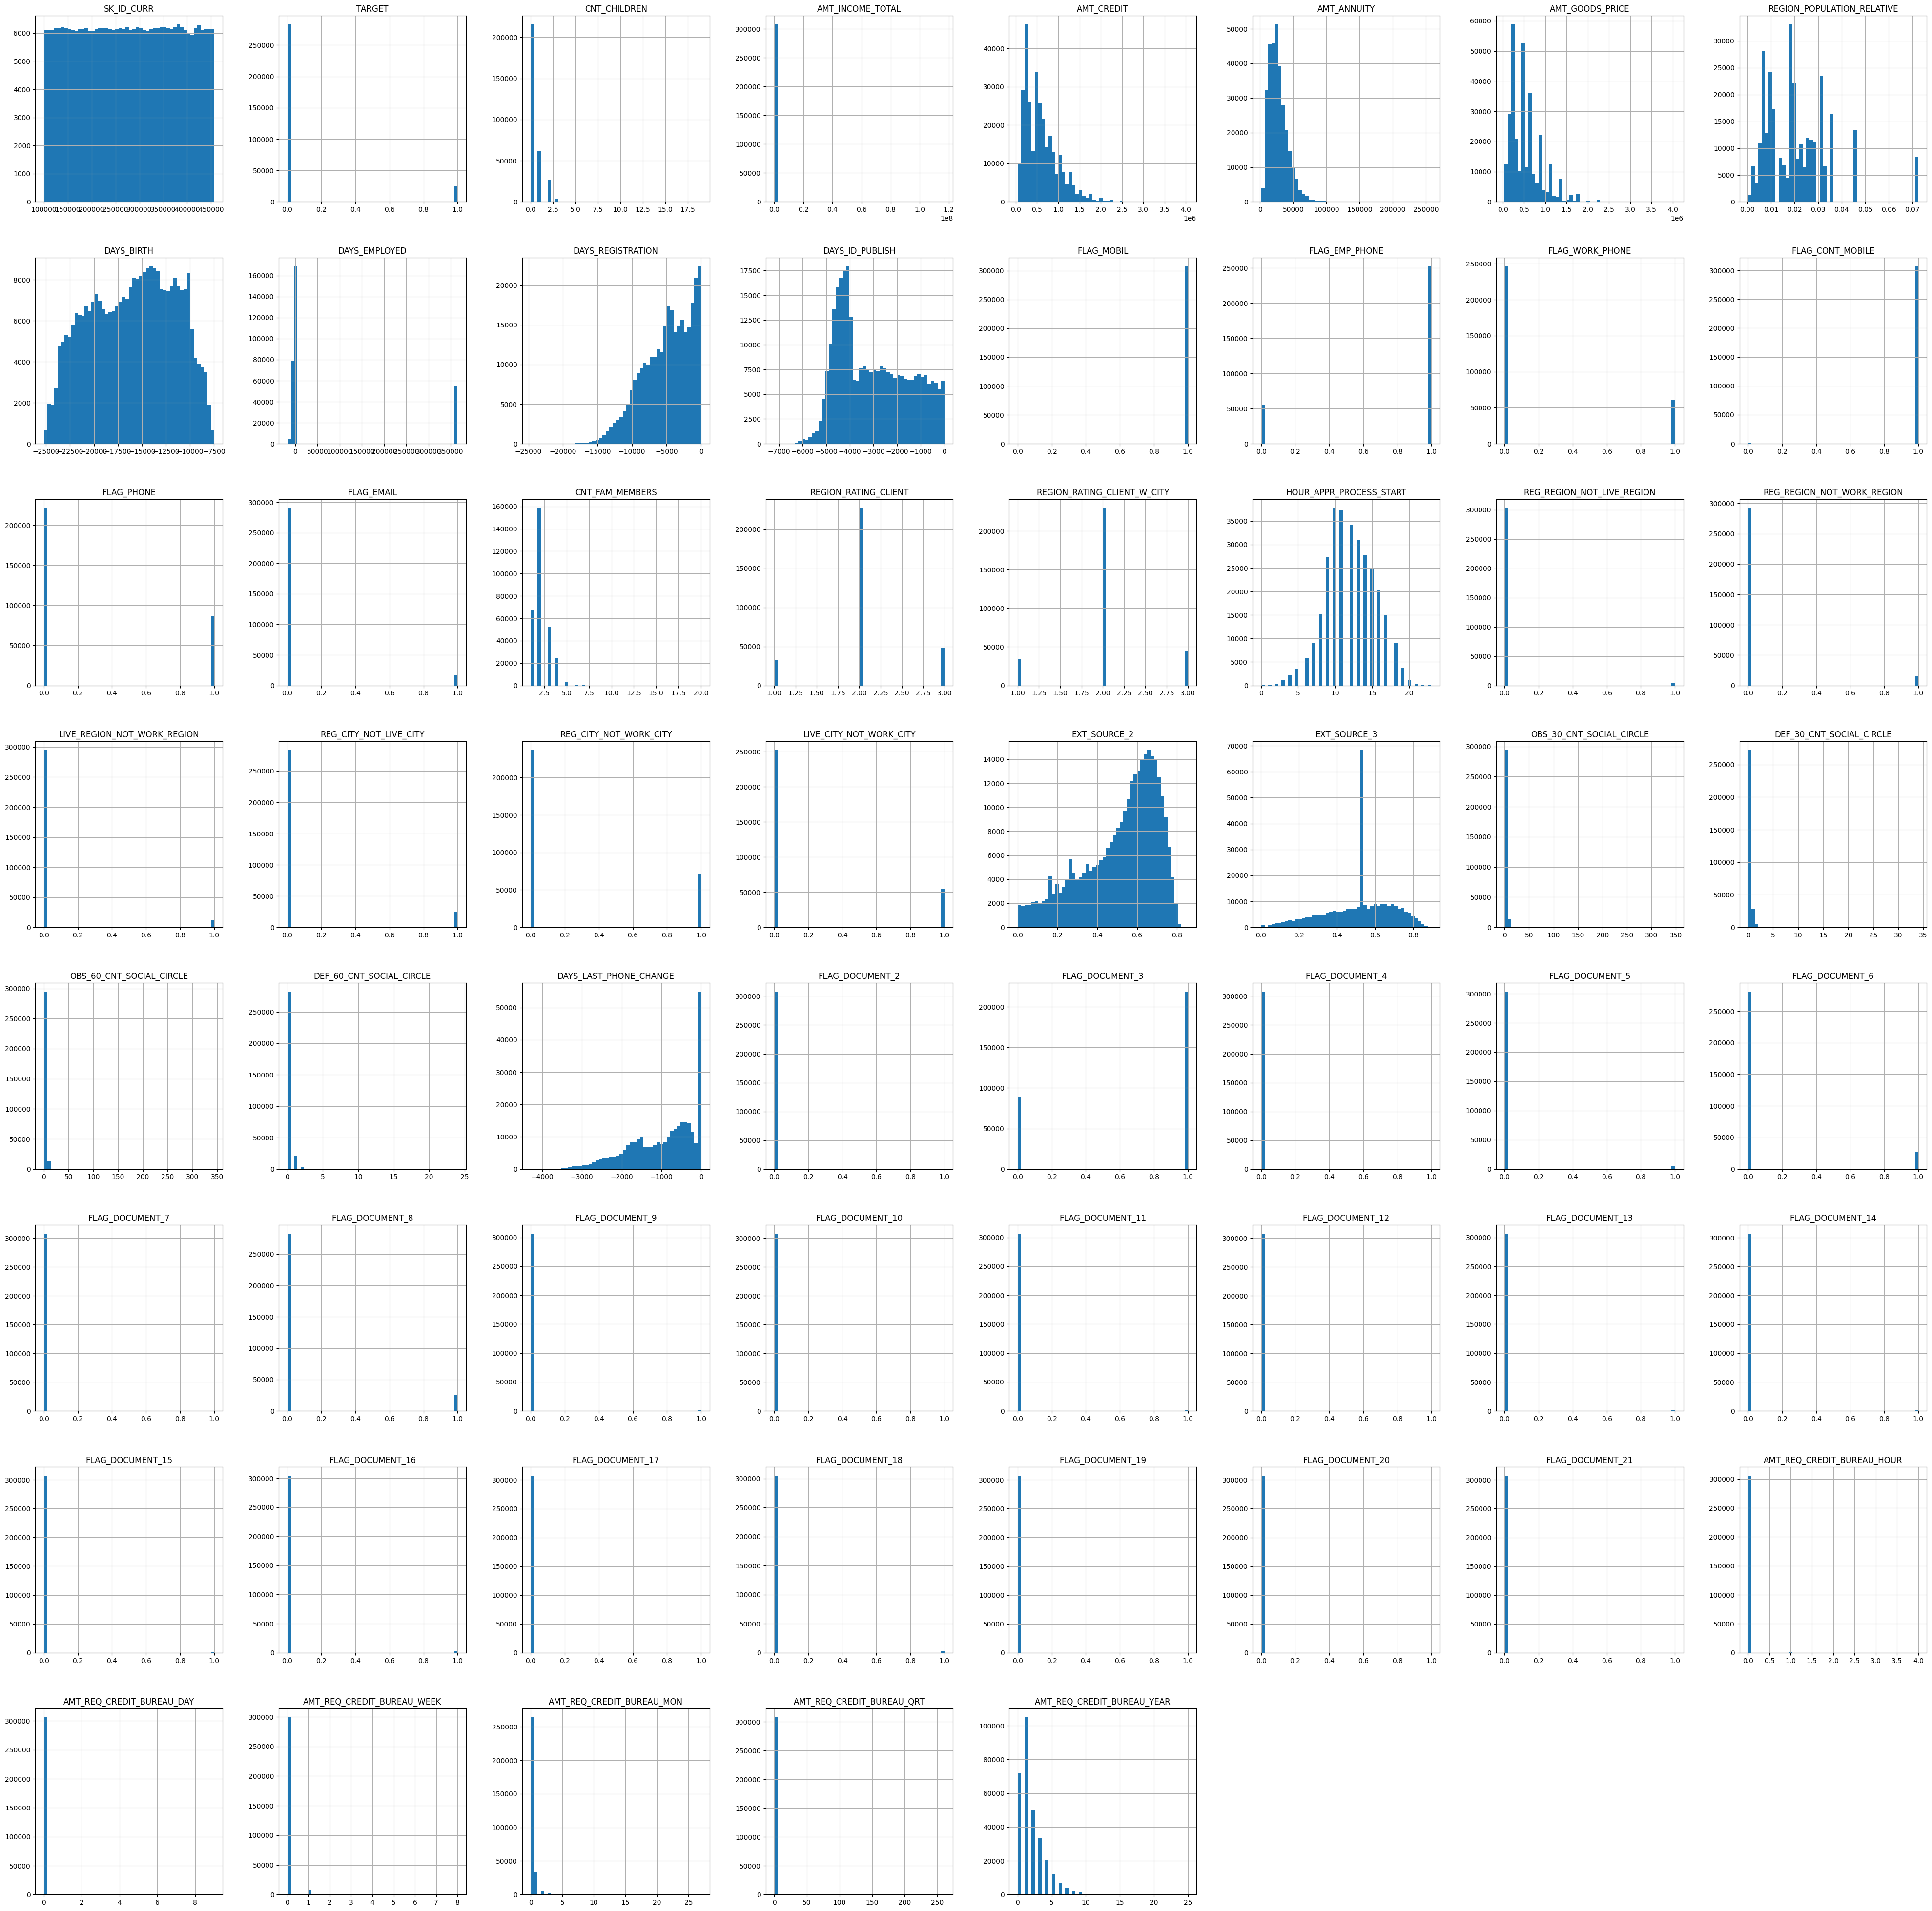

In [17]:
df.hist(bins=50, figsize=(50,50))

## 5. Train / Test Split 

We now:
1. Separate features (`X`) and target (`y`).
2. Use a stratified split so the minority class (default = 1) keeps the same proportion in train and test.

This prevents data leakage and gives us an honest test set for evaluation.

In [18]:
X= df.drop('TARGET', axis=1)
y=df['TARGET']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((246008, 72), (246008,), (61503, 72), (61503,))

In [19]:
X_train.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
181648,310536,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
229245,365516,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## 6. Preprocessing

The dataset mixes numeric and categorical features.

Steps:
- Scale numeric features with `StandardScaler` so models aren’t biased by raw magnitudes.
- One-hot encode categorical features with `OneHotEncoder` (unseen categories at test time are ignored).
- Concatenate scaled numeric features + encoded categorical features.
- Clean column names to remove special characters so libraries like LightGBM/CatBoost don't complain.

After this step, `X_train_final` and `X_test_final` are fully numeric and model-ready.

In [20]:
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(include='object').columns

scaler = StandardScaler()
X_train_num_cols = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train[cat_cols]), columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)

In [21]:
X_train_num_cols.head(5).round(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
181648,0.31,2.20,-0.30,-0.92,-0.96,-0.97,-0.91,0.86,-0.46,-0.39,...,-0.09,-0.02,-0.02,-0.02,-0.07,-0.06,-0.15,-0.27,1.34,-0.44
229245,0.85,-0.58,-0.30,-1.09,-0.97,-1.09,-1.29,0.15,-0.45,1.05,...,-0.09,-0.02,-0.02,-0.02,-0.07,-0.06,-0.15,-0.27,-0.40,-0.44
122525,-0.35,-0.58,-0.13,0.32,-0.06,0.04,-0.01,-0.75,-0.46,-0.84,...,-0.09,-0.02,-0.02,-0.02,-0.07,-0.06,10.30,-0.27,-0.40,0.13
306311,1.72,-0.58,-0.13,-0.31,0.52,-0.40,-0.66,-0.40,-0.46,1.12,...,-0.09,-0.02,-0.02,-0.02,-0.07,-0.06,-0.15,-0.27,-0.40,1.26
300658,1.65,-0.58,0.04,-0.86,0.03,-0.85,-1.03,1.73,-0.46,0.60,...,-0.09,-0.02,-0.02,-0.02,-0.07,-0.06,-0.15,-0.27,-0.40,-0.44


In [22]:
X_train_cat_ohe.head(5)

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
181648,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229245,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122525,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306311,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300658,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X_train_num_cols.shape, X_train_cat_ohe.shape

((246008, 60), (246008, 124))

In [24]:
X_train_final = pd.concat([X_train_num_cols, X_train_cat_ohe], axis=1)
X_train_final.shape

(246008, 184)

In [25]:
X_test_num_cols = pd.DataFrame(scaler.transform(X_test[num_cols]),columns=num_cols,index=X_test.index)
X_test_cat_ohe = pd.DataFrame(ohe.transform(X_test[cat_cols]),columns=ohe.get_feature_names_out(cat_cols),index=X_test.index)

X_test_final = pd.concat([X_test_num_cols, X_test_cat_ohe], axis=1)

In [26]:
X_train_final.shape, X_test_final.shape

((246008, 184), (61503, 184))

Some special characters like "_" caused LightGBM to output an error, thus removing such special characters will help eleviate the model.

In [27]:
X_train_final.columns = X_train_final.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test_final.columns = X_test_final.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

## 7. Class Imbalance Handling (SMOTE)

Default cases (TARGET = 1) are rare compared to non-default (TARGET = 0).  
If we train directly on raw data, most models will just learn “predict 0”.

To fix that, we use **SMOTE (Synthetic Minority Oversampling Technique)**:
- It synthesizes new minority-class samples in feature space.
- We apply SMOTE **only on the training set** (never on test).

We then realign column names and ensure the test set has identical columns.


In [28]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_final,y_train)

In [29]:
def clean_columns_case_safe(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace('[^A-Za-z0-9_]+', '_', regex=True)
        .str.replace('__+', '_', regex=True)
    )
    return df

X_train_smote = clean_columns_case_safe(X_train_smote)
X_test_final  = clean_columns_case_safe(X_test_final)
X_test_final  = X_test_final.reindex(columns=X_train_smote.columns, fill_value=0)


In [30]:
X_train_smote.shape, y_train_smote.shape

((452296, 184), (452296,))

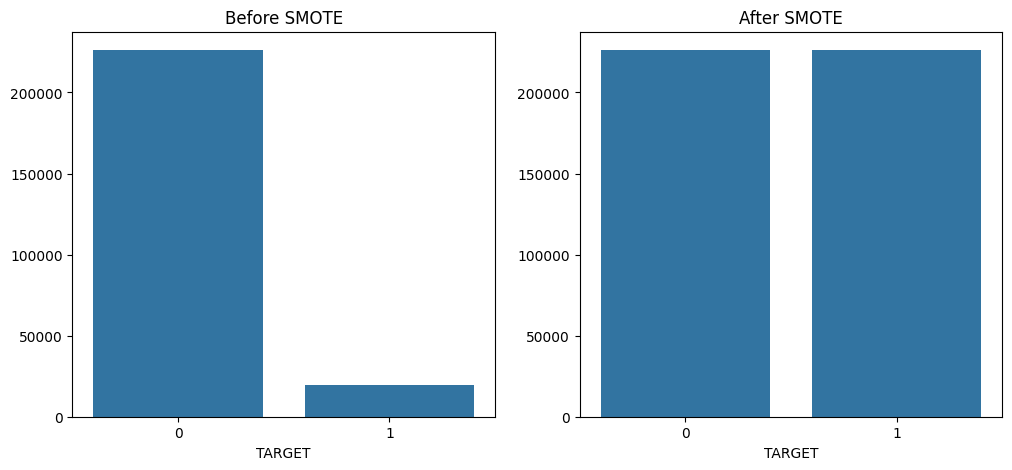

In [31]:
before_smote = y_train.value_counts()
after_smote = y_train_smote.value_counts()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x=before_smote.index, y=before_smote.values)
plt.title('Before SMOTE')
plt.subplot(1,2,2)
sns.barplot(x=after_smote.index, y=after_smote.values)
plt.title('After SMOTE')
plt.show()

### Class distribution before vs after SMOTE


## 8. Modeling

We train and compare 3 gradient boosting models:

- **XGBoost**: Strong baseline for tabular credit risk.
- **LightGBM**: Optimized for speed and large feature spaces.
- **CatBoost**: Handles categorical signals well and is often strong out of the box.

All models are trained on the SMOTE-balanced training data (`X_train_smote`, `y_train_smote`).


In [32]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [33]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 226148, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33942
[LightGBM] [Info] Number of data points in the train set: 452296, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [34]:
cat_boost = CatBoostClassifier(
    random_state=42,
    iterations=300,          # fewer boosting rounds
    learning_rate=0.03,      # slower learning
    depth=6,                 # less overfitting
    l2_leaf_reg=5,           # stronger regularization
    eval_metric='AUC',
    verbose=100
)
cat_boost.fit(X_train_smote, y_train_smote)

0:	total: 235ms	remaining: 1m 10s
100:	total: 7.67s	remaining: 15.1s
200:	total: 15.1s	remaining: 7.43s
299:	total: 22.2s	remaining: 0us


## 9. Evaluation

We evaluate each model on the untouched test set (`X_test_final`, `y_test`) using:
- **Confusion Matrix** (how many defaults we catch)
- **Classification Report** (precision / recall / F1)
- **ROC-AUC** (ranking quality; higher is better)

Note: accuracy alone is misleading for imbalanced problems, so we rely more on ROC-AUC and recall for the minority class.


In [35]:
y_pred_cb = cat_boost.predict(X_test_final)
y_proba_cb = cat_boost.predict_proba(X_test_final)[:, 1]

print("CatBoost Results")
print(confusion_matrix(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb, zero_division=0))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_cb))

CatBoost Results
[[56513    25]
 [ 4934    31]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.55      0.01      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503

ROC-AUC Score: 0.7436111822696617


In [36]:
for model in [xgb, lgbm, cat_boost]:
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]
    print(f"Model: {model.__class__.__name__}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    print("-" * 50)

Model: XGBClassifier
[[56361   177]
 [ 4791   174]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.50      0.04      0.07      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.52      0.51     61503
weighted avg       0.89      0.92      0.89     61503

ROC-AUC Score: 0.7454555192798349
--------------------------------------------------
Model: LGBMClassifier
[[56480    58]
 [ 4898    67]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.54      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503

ROC-AUC Score: 0.7477049417021775
--------------------------------------------------
Model: CatBoostClassifier
[[56513    25]
 [ 4934    31]]
              

### Performance Summary (Test Set)

| Model        | ROC-AUC | Notes                                  |
|-------------|---------|----------------------------------------|
| XGBoost     | ~0.74   | Best overall ranking of risky clients  |
| LightGBM    | ~0.71   | Slightly weaker recall on defaulters   |
| CatBoost    | ~0.73   | Strong alternative, stable performance |

**Takeaway:** XGBoost delivered the best tradeoff between false alarms and catching real defaults.


## 10. Feature Importance

Which features drive the model most?

We visualize the top 15 most important features according to each model.  
Common high-signal features:
- External risk scores (EXT_SOURCE_2, EXT_SOURCE_3)
- Credit/annuity amounts
- Applicant age (DAYS_BIRTH)
- Employment length (DAYS_EMPLOYED)

These align with intuition: income stability, debt load, and age/employment history matter for creditworthiness.


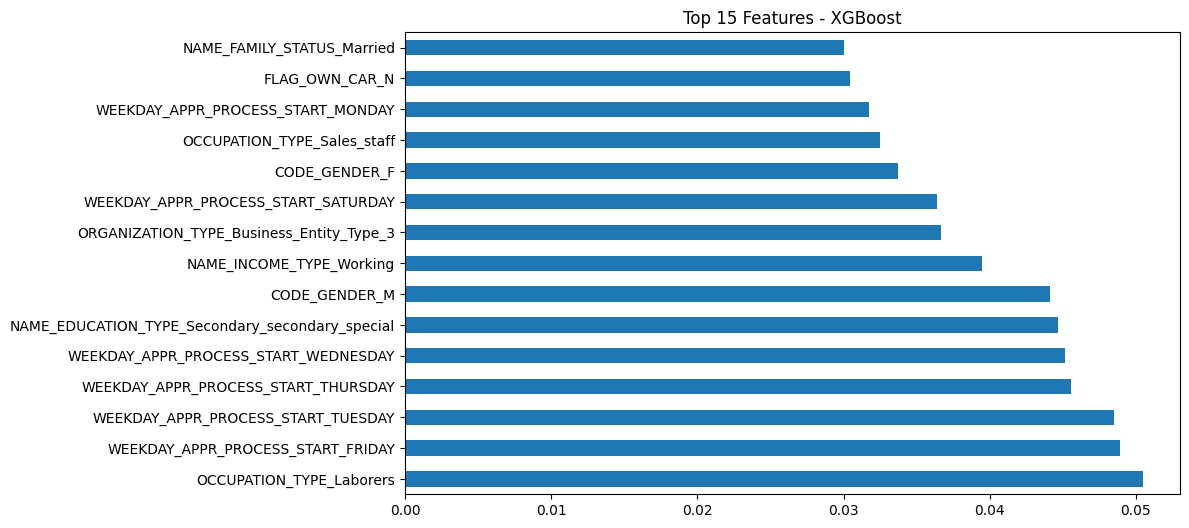

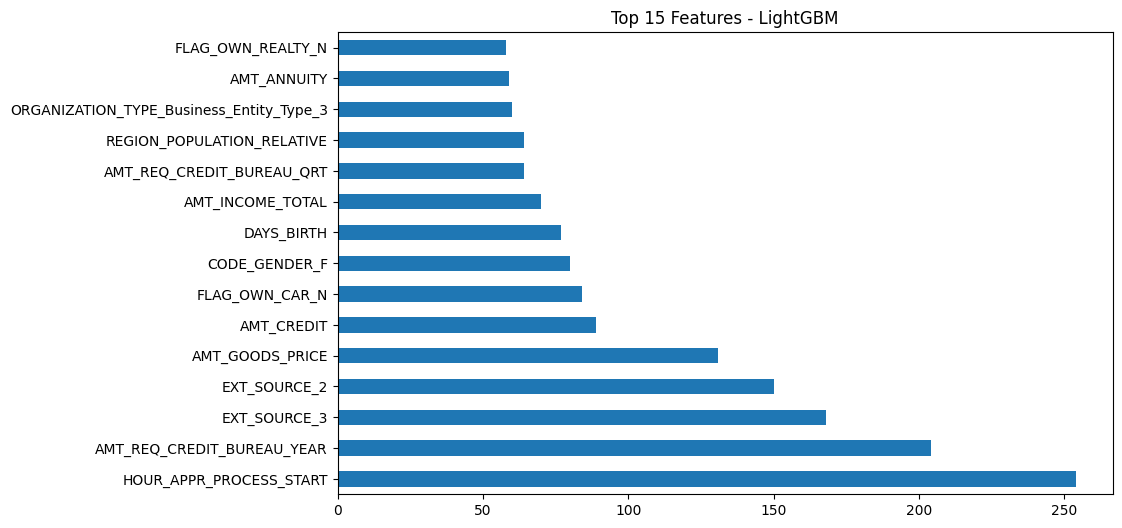

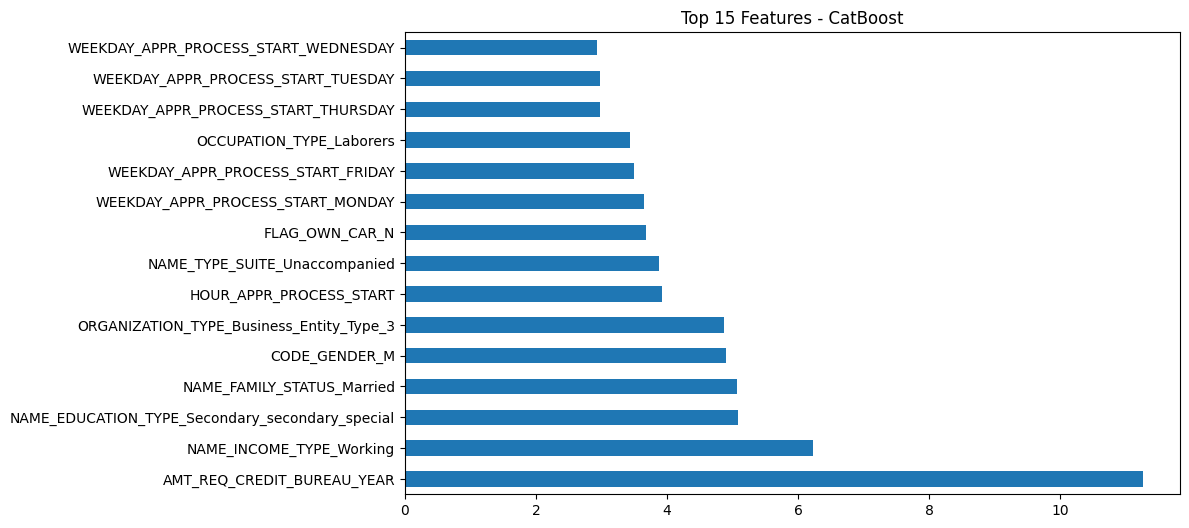

In [37]:
def plot_feature_importances(model, model_name):
    fi = pd.Series(model.feature_importances_, index=X_train_smote.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    fi.head(15).plot(kind='barh')
    plt.title(f"Top 15 Features - {model_name}")
    plt.show()

plot_feature_importances(xgb, "XGBoost")
plot_feature_importances(lgbm, "LightGBM")
plot_feature_importances(cat_boost, "CatBoost")

## 11. Export Model Artifacts

We export:
- The fitted XGBoost model (`xgb_model.pkl`)
- The list of feature columns after preprocessing (`feature_columns.pkl`)

These can be loaded later in a Streamlit app or API to score new applicants.


In [38]:
joblib.dump(X_train_final.columns, "feature_columns.pkl")
joblib.dump(xgb, 'xgb_model.pkl')

['xgb_model.pkl']

## 12. Conclusion / Next Steps

**What was done**
- Cleaned and preprocessed a real-world credit risk dataset
- Handled missingness and mixed datatypes
- Dealt with severe class imbalance using SMOTE
- Trained XGBoost, LightGBM, and CatBoost
- Evaluated using ROC-AUC, precision/recall, and confusion matrices
- Identified the most predictive features
- Saved the final model and its feature schema for deployment

**Why this matters**
This is exactly what banks / lenders do in production: they forecast probability of default to make lending decisions and monitor portfolio risk.

**Future work**
- Hyperparameter tuning for XGBoost / CatBoost
- SHAP explainability dashboards for regulators / audit
- Fairness audit across demographics
- Live scoring app (Streamlit or FastAPI)
